
  Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшении работы нейронной сети. Обучите на выбор:

    *VAE на fashion_mnist

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# слой семплирования sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a picture."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# энкодер encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
# decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
# класс модель по Model с особым шагом обучения train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [6]:
# Convolutional Variational AutoEncoder (VAE)

(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_images = np.concatenate([x_train, x_test], axis=0)
mnist_images = np.expand_dims(mnist_images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_images, epochs=20, batch_size=128)

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - 21s 18ms/step - loss: 303.7898 - reconstruction_loss: 300.2166 - kl_loss: 3.5732
Epoch 2/20
547/547 [==============================] - 10s 18ms/step - loss: 269.5400 - reconstruction_loss: 266.0249 - kl_loss: 3.5151
Epoch 3/20
547/547 [==============================] - 10s 18ms/step - loss: 266.2266 - reconstruction_loss: 262.6973 - kl_loss: 3.5293
Epoch 4/20
547/547 [==============================] - 10s 18ms/step - loss: 264.4770 - reconstruction_loss: 260.9282 - kl_loss: 3.5487
Epoch 5/20
547/547 [==============================] - 10s 18ms/step - loss: 263.3352 - reconstruction_loss: 259.7772 - kl_loss: 3.5580
Epoch 6/20
547/547 [==============================] - 10s 18ms/step - loss: 262.3242 - reconstruction_loss: 258.7638 - kl_loss: 3.5605
Epoch 7/20
547/547 [==============================] - 10s 18ms/step - loss: 261.5999 - reconstruction_loss: 258.0197 - kl_loss:

In [7]:
vae.fit(mnist_images, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 10s 18ms/step - loss: 256.8040 - reconstruction_loss: 253.1330 - kl_loss: 3.6710
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 256.5921 - reconstruction_loss: 252.9214 - kl_loss: 3.6707
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 256.3992 - reconstruction_loss: 252.7100 - kl_loss: 3.6892
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 256.0979 - reconstruction_loss: 252.4187 - kl_loss: 3.6792
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 256.0553 - reconstruction_loss: 252.3685 - kl_loss: 3.6868
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 255.8576 - reconstruction_loss: 252.1663 - kl_loss: 3.6912
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 255.6641 - reconstruction_loss: 251.9695 - kl_loss: 3.6946
Epoch 8/30
547/547 [==============================] - 1

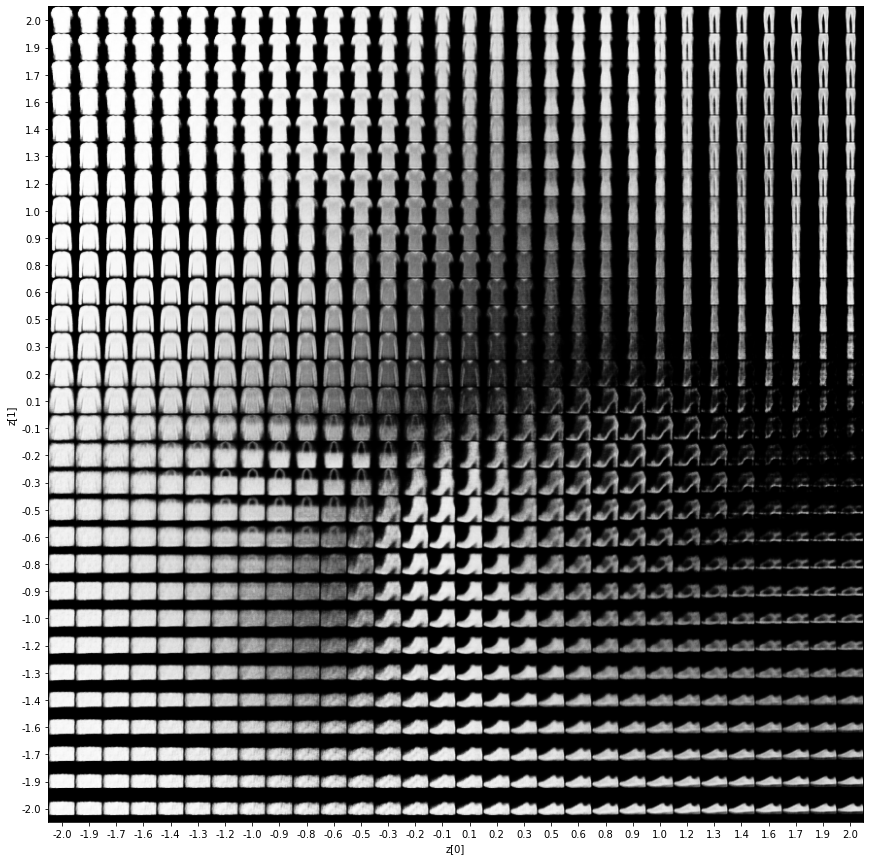

In [8]:
# pезультат предсказания для предмета

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range #+ 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

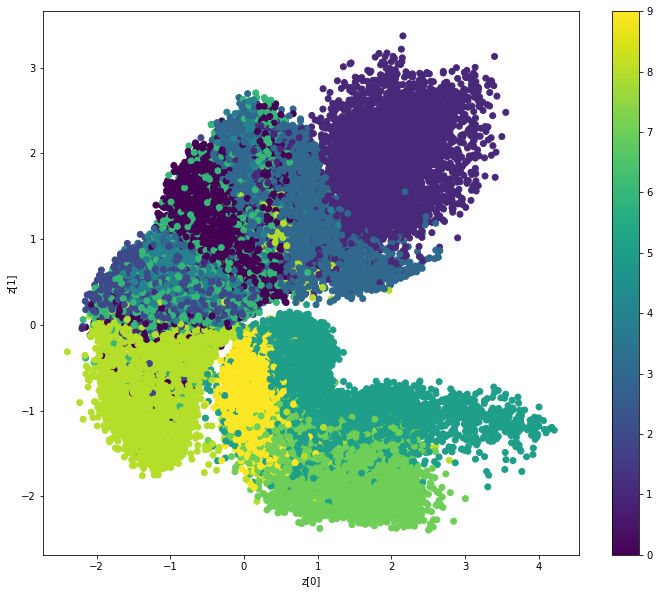

In [9]:
# кластеры в скрытом пространстве

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

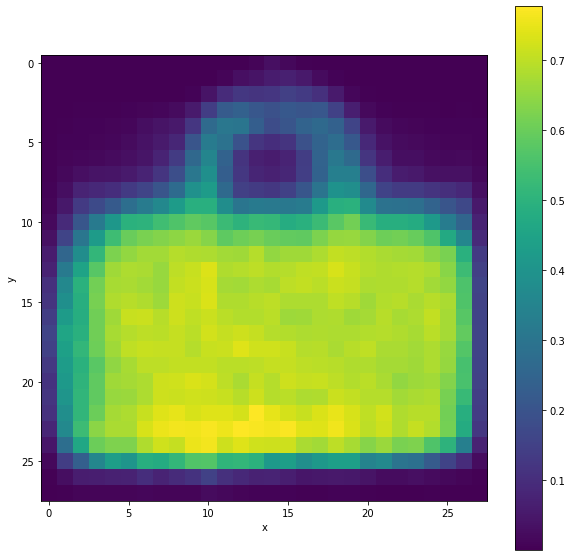

In [10]:
# 2D-графика классов предметов в скрытом пространстве

def plot_item_from_decoder(decoder, z, item_size):
    
    data = np.array([[z[0], z[1]]])
    item = decoder.predict(data)
    item = item.reshape(item_size, item_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(item)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_item_from_decoder(decoder, [-1,-0.5], 28)



Выводы:

  Точность результата увеличивается при увеличении количества эпох и заметно снижается при уменьшении размера batch.

  При увеличении размера batch точность повышается, но кластеры выстраиваются в прямую линию, демонстрируя переобучение.

